## Acquire and Prep

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import sklearn.linear_model
from sklearn.model_selection import train_test_split

import env
import split_scale

from math import sqrt
%matplotlib inline

**SQL query to use for the MVP model**

In [2]:
query = """
SELECT 
bathroomcnt AS bath_count,
bedroomcnt AS bedroom_count,
calculatedfinishedsquarefeet AS sqft,
fips,
taxvaluedollarcnt AS assessed_tax_value,                                                                            
(taxamount / taxvaluedollarcnt) AS tax_rate
FROM properties_2017
JOIN predictions_2017 AS pr USING(`parcelid`)
WHERE (transactiondate >= '2017-05-01' AND transactiondate <= '2017-06-30') AND
propertylandusetypeid = 261;"""

In [3]:
#add get_db_url to wrangle.py
URL = env.get_db_url("zillow")

In [4]:
zillow = pd.read_sql(query, URL)

**Take a peek at the data**

In [5]:
zillow.sample(4)

,bath_count,bedroom_count,sqft,fips,assessed_tax_value,tax_rate
13061,3.0,4.0,1647.0,6037.0,583771.0,0.011554
8730,2.5,3.0,1587.0,6059.0,245760.0,0.012079
11308,3.0,4.0,3460.0,6037.0,860797.0,0.011539
4146,1.5,2.0,1392.0,6059.0,87651.0,0.014716


**Bring in the fips**

In [6]:
FIPS = pd.read_csv("FIPS.txt", sep="\t")

In [7]:
FIPS

,FIPS,Name,State
0,1001,Autauga,AL
1,1003,Baldwin,AL
2,1005,Barbour,AL
3,1007,Bibb,AL
4,1009,Blount,AL
...,...,...,...
3227,72151,Yabucoa,PR
3228,72153,Yauco,PR
3229,78010,St. Croix,VI
3230,78020,St. John,VI


In [8]:
zillow = pd.merge(left=zillow, right=FIPS, left_on="fips", right_on="FIPS")

In [9]:
zillow

,bath_count,bedroom_count,sqft,fips,assessed_tax_value,tax_rate,FIPS,Name,State
0,2.0,3.0,1458.0,6037.0,136104.0,0.017045,6037,Los Angeles,CA
1,1.0,2.0,1421.0,6037.0,35606.0,0.015270,6037,Los Angeles,CA
2,2.0,3.0,1650.0,6037.0,614000.0,0.012497,6037,Los Angeles,CA
3,1.0,2.0,693.0,6037.0,274237.0,0.011915,6037,Los Angeles,CA
4,0.0,0.0,1378.0,6037.0,168828.0,0.012648,6037,Los Angeles,CA
...,...,...,...,...,...,...,...,...,...
15031,2.0,3.0,1575.0,6111.0,506000.0,0.010707,6111,Ventura,CA
15032,2.0,3.0,1645.0,6111.0,230986.0,0.012363,6111,Ventura,CA
15033,2.0,3.0,1308.0,6111.0,255407.0,0.010919,6111,Ventura,CA
15034,2.5,4.0,2314.0,6111.0,485364.0,0.019674,6111,Ventura,CA


In [10]:
zillow.rename(columns = {"Name": "county_name"}, inplace = True)

Check the datatypes and info

In [11]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            15036 non-null float64
bedroom_count         15036 non-null float64
sqft                  15012 non-null float64
fips                  15036 non-null float64
assessed_tax_value    15036 non-null float64
tax_rate              15035 non-null float64
FIPS                  15036 non-null int64
county_name           15036 non-null object
State                 15036 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


let's check to see how many zeros are in bed and bath

In [12]:
zillow.bath_count.value_counts()

2.0     6182
3.0     3114
1.0     2652
2.5     1155
4.0      671
3.5      302
1.5      240
5.0      233
4.5      217
6.0      102
5.5       65
0.0       40
7.0       25
6.5       15
8.0       14
7.5        4
9.0        3
11.0       1
10.0       1
Name: bath_count, dtype: int64

In [13]:
zillow.bedroom_count.value_counts()

3.0     6668
4.0     4423
2.0     2350
5.0     1158
6.0      183
1.0      177
0.0       42
7.0       27
12.0       3
9.0        2
11.0       1
10.0       1
8.0        1
Name: bedroom_count, dtype: int64

I'm going to drop the zeros in bed and bath to get my MVP out as fast as possible.

- If thime permits later I might try to replace with mean or mode

In [14]:
zillow.bath_count.replace(0, np.nan, inplace=True)

In [15]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            14996 non-null float64
bedroom_count         15036 non-null float64
sqft                  15012 non-null float64
fips                  15036 non-null float64
assessed_tax_value    15036 non-null float64
tax_rate              15035 non-null float64
FIPS                  15036 non-null int64
county_name           15036 non-null object
State                 15036 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


In [16]:
zillow.bedroom_count.replace(0, np.nan, inplace=True)

In [17]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15036 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            14996 non-null float64
bedroom_count         14994 non-null float64
sqft                  15012 non-null float64
fips                  15036 non-null float64
assessed_tax_value    15036 non-null float64
tax_rate              15035 non-null float64
FIPS                  15036 non-null int64
county_name           15036 non-null object
State                 15036 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


In [18]:
zillow.dropna(inplace=True)

In [19]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14989 entries, 0 to 15035
Data columns (total 9 columns):
bath_count            14989 non-null float64
bedroom_count         14989 non-null float64
sqft                  14989 non-null float64
fips                  14989 non-null float64
assessed_tax_value    14989 non-null float64
tax_rate              14989 non-null float64
FIPS                  14989 non-null int64
county_name           14989 non-null object
State                 14989 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 1.1+ MB


In [20]:
#drop fips since they have no value to us now
zillow.drop(columns=["fips", "FIPS"], inplace=True)

In [21]:
zillow["tax_percentage"] = zillow.tax_rate * 100

In [22]:
zillow.head()

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage
0,2.0,3.0,1458.0,136104.0,0.017045,Los Angeles,CA,1.704505
1,1.0,2.0,1421.0,35606.0,0.015270,Los Angeles,CA,1.526962
2,2.0,3.0,1650.0,614000.0,0.012497,Los Angeles,CA,1.249705
3,1.0,2.0,693.0,274237.0,0.011915,Los Angeles,CA,1.191477
5,2.0,3.0,1108.0,486866.0,0.012304,Los Angeles,CA,1.230421


In [23]:
zillow.county_name.value_counts()

Los Angeles    9604
Orange         4094
Ventura        1291
Name: county_name, dtype: int64

## Distribution of Tax Rates

In [24]:
la_county = zillow[zillow.county_name == "Los Angeles"]

In [25]:
orange_county = zillow[zillow.county_name == "Orange"]

In [26]:
ventura_county = zillow[zillow.county_name == "Ventura"]

**Let's look at the mean median and mode of each county as well as the overall**

In [115]:
county_mean = pd.DataFrame(zillow.groupby("county_name").tax_rate.mean()) * 100
county_mean.columns = ['Mean Tax Rate %']

In [116]:
county_median = pd.DataFrame(zillow.groupby("county_name").tax_rate.median()) * 100
county_median.columns = ['Median Tax Rate %']

In [136]:
county_max = pd.DataFrame(zillow.groupby("county_name").tax_rate.max()) * 100
county_max.columns = ['Max Tax Rate %']

In [137]:
county_min = pd.DataFrame(zillow.groupby("county_name").tax_rate.min()) * 100
county_min.columns = ['Min Tax Rate %']

In [144]:
county_std = pd.DataFrame(zillow.groupby("county_name").tax_rate.std())
county_std.columns = ['AVG STD of Tax Rates']

In [145]:
summary1 = pd.merge(county_mean, county_median, left_index=True, right_index=True)

In [146]:
summary2 = pd.merge(county_max , county_min , left_index=True, right_index=True)

In [147]:
summary3 = pd.merge(summary1 , summary2 , left_index=True, right_index=True)

In [148]:
pd.merge(summary3 , county_std , left_index=True, right_index=True)

,Mean Tax Rate %,Median Tax Rate %,Max Tax Rate %,Min Tax Rate %,AVG STD of Tax Rates
county_name,,,,,
Los Angeles,1.417333,1.263436,45.288365,0.107132,0.007667
Orange,1.212074,1.152400,10.735031,0.171235,0.003221
Ventura,1.205379,1.124874,29.486491,0.078687,0.008288


LA has some serious outliers and so does Ventura

Text(0.5, 1.0, 'Ventura County')

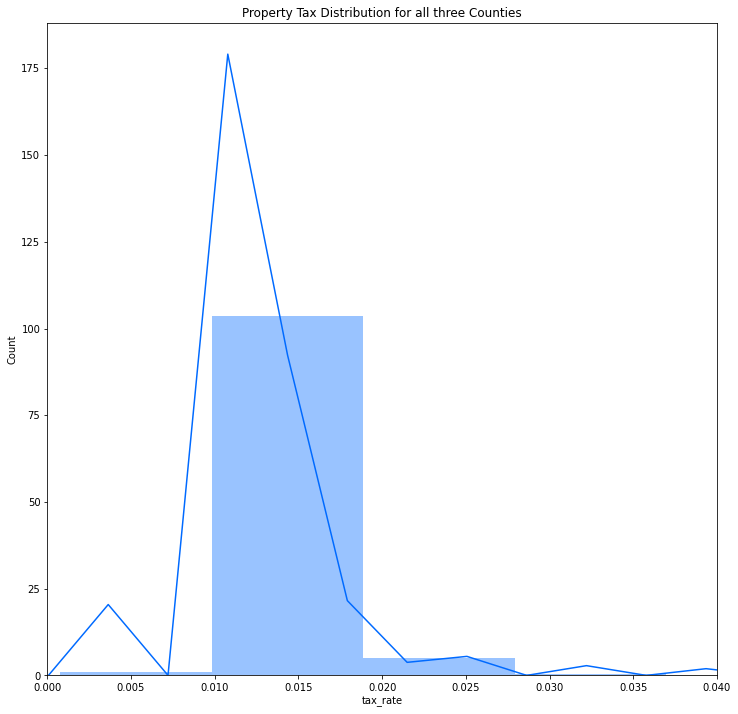

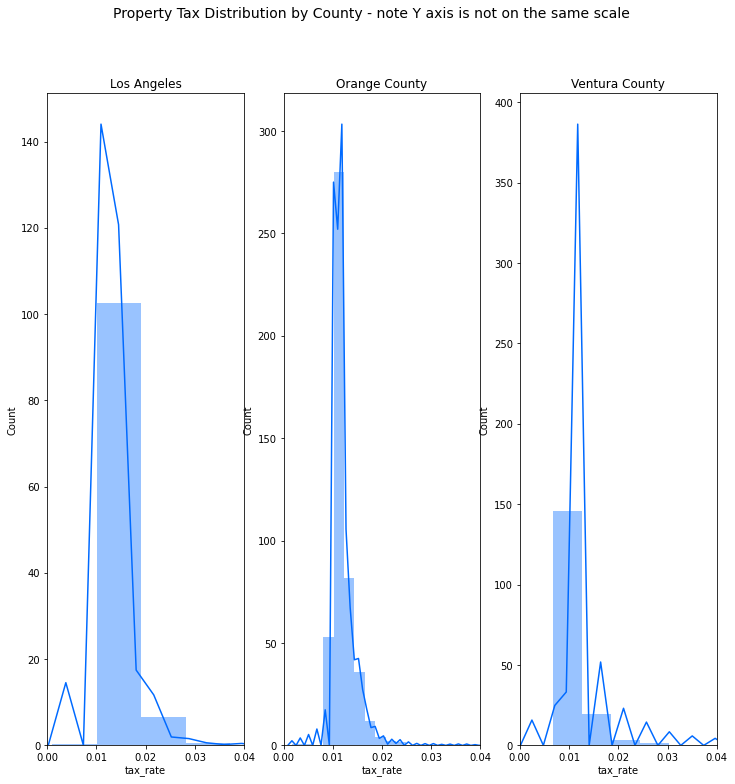

In [103]:
c="#006AFF"

plt.figure(figsize=(12,12))
sns.distplot(zillow.tax_rate, color=c)
plt.xlim(0, 0.04)
plt.ylabel("Count")
plt.title("Property Tax Distribution for all three Counties")

plt.figure(figsize=(12,12))

plt.suptitle('Property Tax Distribution by County - note Y axis is not on the same scale', fontsize=14)

plt.subplot(1, 3, 1)
sns.distplot(la_county.tax_rate, color=c)
plt.xlim(0, 0.04)
plt.ylabel("Count")
plt.title("Los Angeles")

plt.subplot(1, 3, 2)
sns.distplot(orange_county.tax_rate, color=c)
plt.xlim(0, 0.04)
plt.ylabel("Count")
plt.title("Orange County")

plt.subplot(1, 3, 3)
sns.distplot(ventura_county.tax_rate, color=c)
plt.xlim(0, 0.04)
plt.ylabel("Count")
plt.title("Ventura County")


## Split the data

In [29]:
def split_my_data(df, train_pct=0.70, seed=123):
    """
    Takes in a dataframe, training pct amount and seed to split the into testing and training df
    seed will default to 123 if not specified
    train_pct defaults to .7 if not specified
    """
    train, test = train_test_split(df, train_size=train_pct, random_state=seed)
    return train, test

In [30]:
train, test = split_my_data(zillow, .7, 123)

In [31]:
train.sample(4)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage
7719,3.0,3.0,1680.0,543906.0,0.012140,Los Angeles,CA,1.213982
5553,2.0,3.0,1243.0,451000.0,0.012242,Los Angeles,CA,1.224226
5200,3.0,5.0,2355.0,682245.0,0.012690,Los Angeles,CA,1.269003
600,2.0,3.0,1120.0,124330.0,0.012305,Los Angeles,CA,1.230516


# Data Exploration

## Initial Hypothesis
- $H_0$ - There will be no linear difference in assessed home values based on sqft, n bedrooms, n of baths
- $H_a$ - There will be a significant linear difference in home values based on the sqft, n bedrooms and n of baths

In [32]:
mvp_df = train[["bath_count", "bedroom_count", "sqft", "assessed_tax_value"]]

In [33]:
X_train = train[["bath_count", "bedroom_count", "sqft"]]

In [34]:
y_train = train.assessed_tax_value

In [35]:
X_train.head()

,bath_count,bedroom_count,sqft
12620,2.5,3.0,1890.0
12666,2.5,4.0,2045.0
2345,2.0,4.0,2250.0
12384,3.0,3.0,1643.0
12603,2.0,4.0,1599.0


In [36]:
y_train.head()

12620    576038.0
12666    557045.0
2345     284163.0
12384    572000.0
12603    350939.0
Name: assessed_tax_value, dtype: float64

In [37]:
alpha = .05

In [38]:
mvp_df.corr()

,bath_count,bedroom_count,sqft,assessed_tax_value
bath_count,1.000000,0.642765,0.858048,0.528742
bedroom_count,0.642765,1.000000,0.631470,0.276186
sqft,0.858048,0.631470,1.000000,0.604807
assessed_tax_value,0.528742,0.276186,0.604807,1.000000


In [39]:
def plot_variable_pairs(dataframe):
    """This function returns a pairplot to help explore relationships"""
    return sns.pairplot(dataframe, kind="reg")

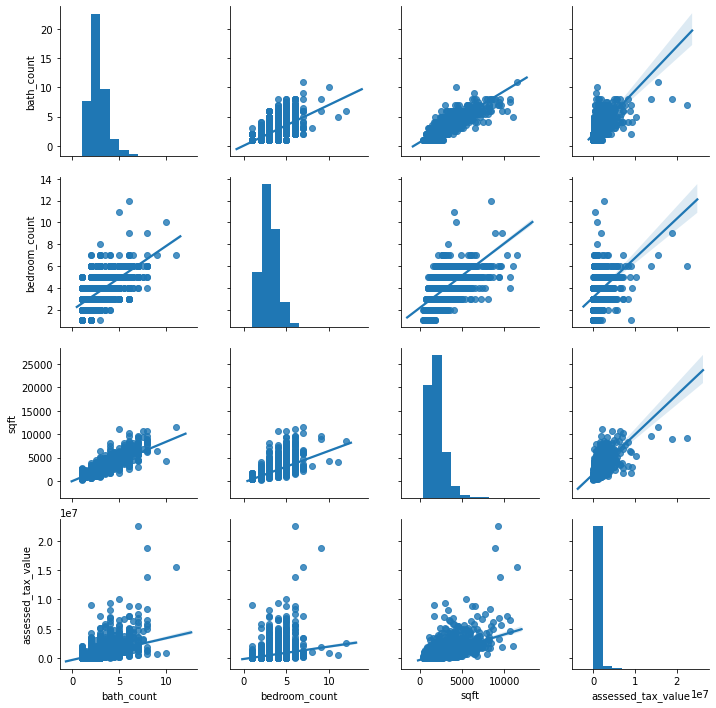

In [40]:
plot_variable_pairs(mvp_df)

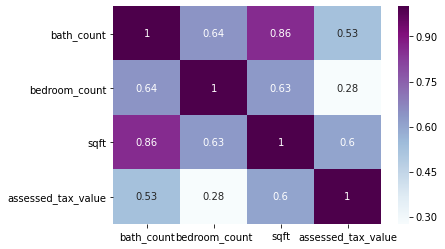

In [41]:
sns.heatmap(mvp_df.corr(), annot=True, cmap="BuPu")

In [42]:
r_bath, p_bath = stats.pearsonr(mvp_df.bath_count, mvp_df.assessed_tax_value)

In [43]:
print(p_bath)

0.0


In [44]:
bedroom_count, p_bedroom_count = stats.pearsonr(mvp_df.bedroom_count, mvp_df.assessed_tax_value)

In [45]:
print(p_bedroom_count)

5.153704730608228e-183


In [46]:
r_sqft, p_sqft = stats.pearsonr(mvp_df.sqft, mvp_df.assessed_tax_value)

In [47]:
print(p_sqft)

0.0


In [48]:
if p_bath < alpha and p_bedroom_count < alpha and p_sqft < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


#### Takeaways on exploration 
- house sqft plays the biggest role in assessed tax value
- bedroom counts and bathroom counts are about the same when it comes to driving assessed tax value

# Modeling
- Establish baseline using the mean assessed_tax_value
- create an OLS model and compare to baseline

In [49]:
X_train = train[["bath_count", "bedroom_count", "sqft"]]
y_train = train.assessed_tax_value

In [50]:
X_train.head()

,bath_count,bedroom_count,sqft
12620,2.5,3.0,1890.0
12666,2.5,4.0,2045.0
2345,2.0,4.0,2250.0
12384,3.0,3.0,1643.0
12603,2.0,4.0,1599.0


In [51]:
y_train.head()

12620    576038.0
12666    557045.0
2345     284163.0
12384    572000.0
12603    350939.0
Name: assessed_tax_value, dtype: float64

- create a dataframe to hold all predictions for easy comparisions later

In [52]:
predictions = pd.DataFrame({"actual": train.assessed_tax_value})

In [53]:
predictions.head()

,actual
12620,576038.0
12666,557045.0
2345,284163.0
12384,572000.0
12603,350939.0


In [54]:
predictions["baseline"] = y_train.mean()

In [55]:
predictions

,actual,baseline
12620,576038.0,544075.261151
12666,557045.0,544075.261151
2345,284163.0,544075.261151
12384,572000.0,544075.261151
12603,350939.0,544075.261151
...,...,...
5234,533298.0,544075.261151
12284,4336027.0,544075.261151
1352,259655.0,544075.261151
11677,2086601.0,544075.261151


In [56]:
all_3_lm = sklearn.linear_model.LinearRegression()

In [57]:
all_3_lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
predictions["sqft_nbath_nbed_lm"] = all_3_lm.predict(X_train)

In [59]:
all_3_lm.coef_, all_3_lm.intercept_

(array([  78490.30220632, -149287.95208061,     453.4930138 ]),
 -29529.831483666552)

In [60]:
sqft_x = train[["sqft"]]

In [61]:
sqft_lm = sklearn.linear_model.LinearRegression()

In [62]:
sqft_lm.fit(sqft_x, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
sqft_lm.coef_, sqft_lm.intercept_

(array([434.01855626]), -304161.8851243417)

In [64]:
predictions["sqft_lm"] = sqft_lm.predict(sqft_x)

In [65]:
n_bed_x = train[["bedroom_count"]]

In [66]:
n_bed_lm = sklearn.linear_model.LinearRegression()

In [67]:
n_bed_lm.fit(n_bed_x, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
n_bed_lm.coef_, n_bed_lm.intercept_

(array([211893.80254284]), -160574.6306254448)

In [69]:
predictions["n_bed_lm"] = n_bed_lm.predict(n_bed_x)

In [70]:
n_bath_x = train[["bedroom_count"]]

In [71]:
n_bath_lm = sklearn.linear_model.LinearRegression()

In [72]:
n_bath_lm.fit(n_bath_x, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
n_bath_lm.coef_, n_bath_lm.intercept_

(array([211893.80254284]), -160574.6306254448)

In [74]:
predictions["n_bath_lm"] = n_bed_lm.predict(n_bath_x)

In [75]:
predictions.head()

,actual,baseline,sqft_nbath_nbed_lm,sqft_lm,n_bed_lm,n_bath_lm
12620,576038.0,544075.261151,575933.863880,516133.186211,475106.777003,475106.777003
12666,557045.0,544075.261151,496937.328939,583406.062432,687000.579546,687000.579546
2345,284163.0,544075.261151,550658.245665,672379.866466,687000.579546,687000.579546
12384,572000.0,544075.261151,503166.240573,408930.602814,475106.777003,475106.777003
12603,350939.0,544075.261151,255434.293679,389833.786339,687000.579546,687000.579546


## Evaluate
- Now that I have a predictions table with my actual, baseline and my MVP linear model I can compare the values

In [76]:
predictions.apply(lambda col: sklearn.metrics.mean_squared_error(predictions.actual, col))

actual                0.000000e+00
baseline              5.230608e+11
sqft_nbath_nbed_lm    3.203972e+11
sqft_lm               3.317297e+11
n_bed_lm              4.831624e+11
n_bath_lm             4.831624e+11
dtype: float64

In [77]:
mse_all_3 = sklearn.metrics.mean_squared_error(predictions.actual, predictions.sqft_nbath_nbed_lm)

In [78]:
rmse_all_3_lm = sqrt(mse_all_3)

In [79]:
rmse_all_3_lm

566036.3557829662

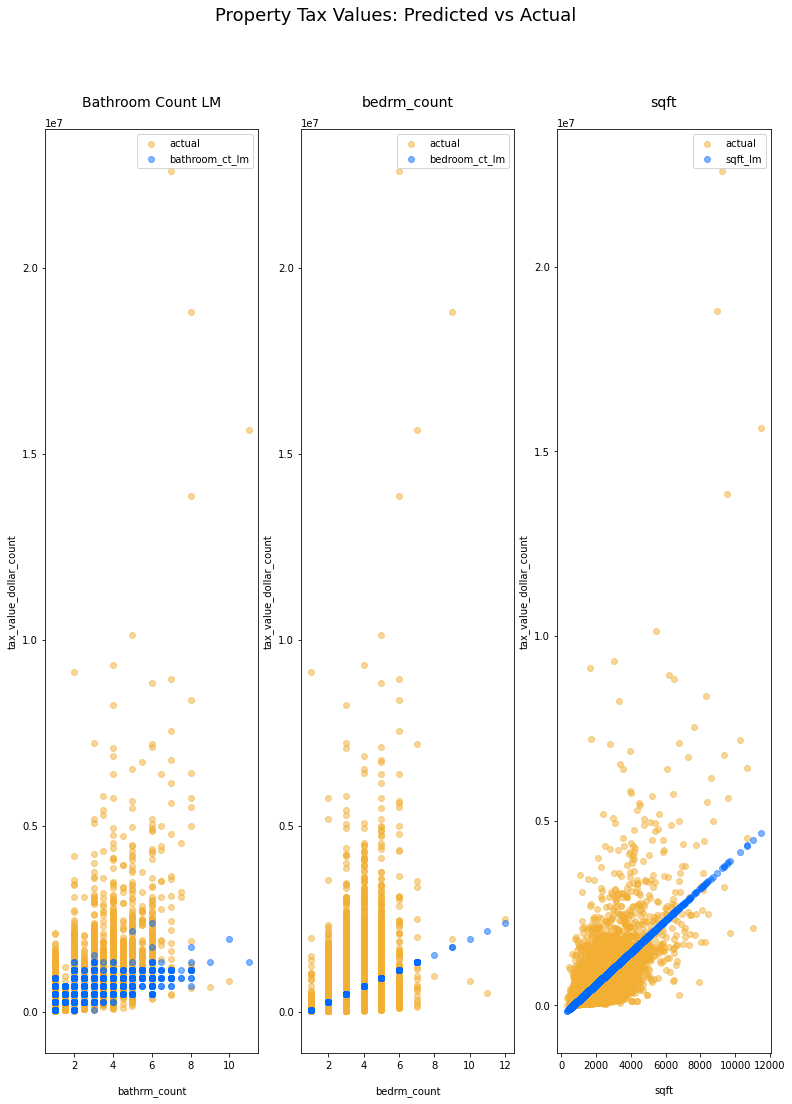

In [80]:
plt.figure(figsize=(13,17))
plt.suptitle('Property Tax Values: Predicted vs Actual\n', fontsize=18)
# Figure 1
plt.subplot(1, 3, 1)
plt.title('Bathroom Count LM\n', fontsize=14)
plt.scatter(X_train.bath_count, y_train, label='actual',alpha=0.5, c="#f2af34ff")
plt.scatter(X_train.bath_count, predictions.n_bath_lm , label='bathroom_ct_lm', alpha=0.5, c="#006AFF")
plt.xlabel('\nbathrm_count')
plt.ylabel('tax_value_dollar_count')
plt.legend()
# Figure 2
plt.subplot(1, 3, 2)
plt.title('bedrm_count\n', fontsize=14)
plt.scatter(X_train.bedroom_count, y_train, label='actual', alpha=0.5, c="#f2af34ff")
plt.scatter(X_train.bedroom_count, predictions.n_bed_lm, label='bedroom_ct_lm',alpha=0.5, c="#006AFF")
plt.xlabel('\nbedrm_count')
plt.ylabel('tax_value_dollar_count')
plt.legend()
# Figure 3
plt.subplot(1, 3, 3)
plt.title('sqft\n', fontsize=14)
plt.scatter(X_train.sqft, y_train, label='actual', alpha=0.5, c="#f2af34ff")
plt.scatter(X_train.sqft, predictions.sqft_lm, label='sqft_lm', alpha=0.5, c="#006AFF")
plt.xlabel('\nsqft')
plt.ylabel('tax_value_dollar_count')
plt.legend()
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:795: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:784: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/relational.py:795: MatplotlibD

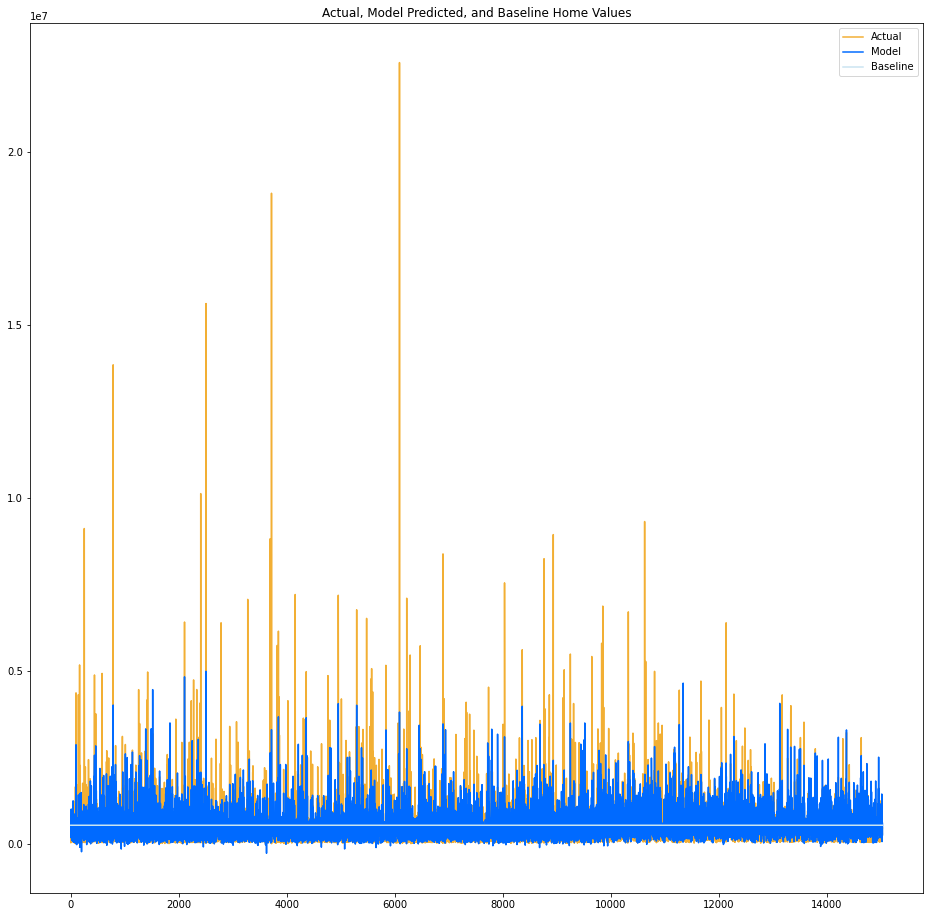

In [81]:
plt.figure(figsize=(16, 16))
plt.title("Actual, Model Predicted, and Baseline Home Values")
sns.lineplot(data=predictions.actual, label="Actual", c="#f2af34ff")
sns.lineplot(data=predictions.sqft_nbath_nbed_lm, label="Model", c="#006AFF")
sns.lineplot(data=predictions.baseline, label="Baseline", c="#cae4f1ff")

Text(0.5, 1.0, 'Predicted vs Actual')

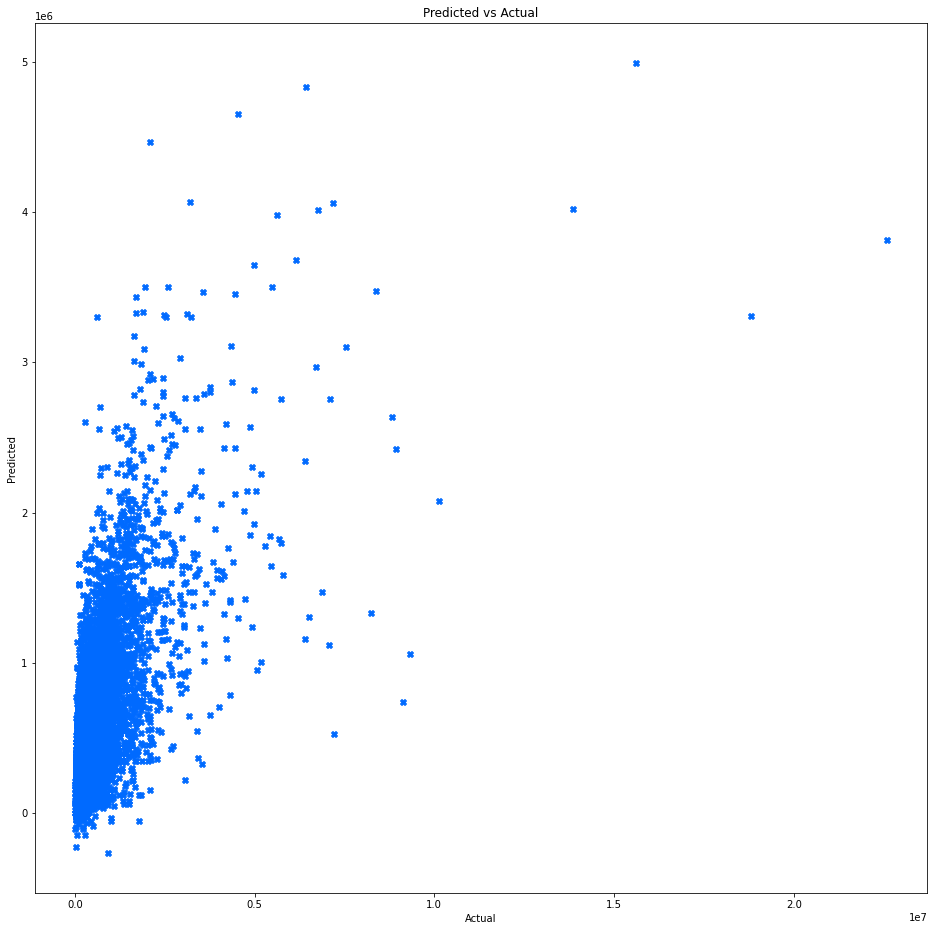

In [82]:
plt.figure(figsize=(16, 16))

plt.scatter(predictions.actual, predictions.sqft_nbath_nbed_lm, label='LinearRegression (assessed_tax_value ~ sqft, bedroom_count, bath_count)', marker='X', c="#006AFF")

plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Predicted vs Actual')

In [83]:
def plot_residuals(actual, predicted, plot_title='Predicted vs Actual'):
    """
    Takes in two values and plots the residuals
    also takes in a plot title string, defaults to Predicted VS Actual if not provided
    """
    residuals = actual - predicted
    plt.figure(figsize=(16, 12))
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals, c="#006AFF", alpha=0.5)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title(plot_title)
    return plt.gca()

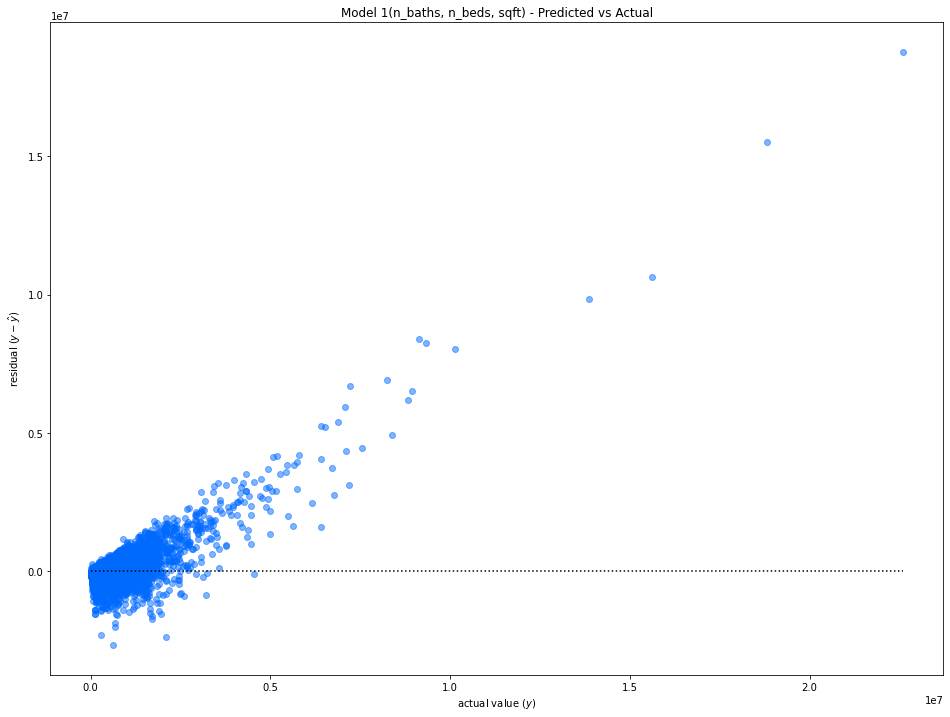

In [84]:
plot_residuals(predictions.actual, predictions.sqft_nbath_nbed_lm, "Model 1(n_baths, n_beds, sqft) - Predicted vs Actual")